In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib notebook
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33


In [2]:
from math import sqrt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
test_samples, test_labels = mnist.test.next_batch(1000)

In [6]:
n_hidden_1 = 1024
n_hidden_2 = 1024
n_hidden_3 = 1024
n_hidden_4 = 1024
n_hidden_5 = 1024
n_features = 784
n_output = 10

In [8]:
x = tf.placeholder('float', shape=[None, n_features])
y = tf.placeholder('float', shape=[None, n_output])

In [9]:
test_pred = tf.placeholder('float', shape=[None, n_output])

In [10]:
# Learning Parameters
batch_size = 100

In [11]:
# Small epsilon value for the BN transform
epsilon = 1e-3

In [30]:
def neural_network_model(data):
    # Weights and bias initialization
    weights = {
        'w1': tf.Variable(tf.random_normal(shape=[n_features, n_hidden_1],stddev=tf.sqrt(2/(n_features+n_hidden_1)))),
        'w2': tf.Variable(tf.random_normal(shape=[n_hidden_1, n_hidden_2],stddev = tf.sqrt(2/(n_hidden_1+ n_hidden_2)))),
        'w3': tf.Variable(tf.random_normal(shape=[n_hidden_2, n_hidden_3],stddev = tf.sqrt(2/(n_hidden_2 + n_hidden_3)))),
        'w4': tf.Variable(tf.random_normal(shape=[n_hidden_3, n_hidden_4],stddev = tf.sqrt(2/(n_hidden_4 + n_hidden_3)))),
        'w5': tf.Variable(tf.random_normal(shape=[n_hidden_4, n_hidden_5],stddev = tf.sqrt(2/(n_hidden_4 + n_hidden_5)))),
        'wout': tf.Variable(tf.random_normal(shape=[n_hidden_5, n_output],stddev = tf.sqrt(2/(n_hidden_5+n_output))))
    }
    biases = {
        #'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        #'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        #'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        #'b4': tf.Variable(tf.random_normal([n_hidden_4])),
        #'b5': tf.Variable(tf.random_normal([n_hidden_5])),
        'bout': tf.Variable(tf.random_normal([n_output]))
    }
    z1 = tf.matmul(x,weights['w1'])
    # Initial batch transformation
    batch_mean1, batch_var1 = tf.nn.moments(z1, [0])
    #z1hat = (z1 - batch_mean1) / tf.sqrt(batch_var1+epsilon)
    # Create two new parameters, scale and beta (shift)
    scale1 = tf.Variable(tf.ones([1024]))
    beta1 = tf.Variable(tf.zeros([1024]))

    # Scale and shift to obtain the final output of the batch normalization
    # this value is fed into the activation function (here a sigmoid)
    z1_hat = tf.nn.batch_normalization(z1, batch_mean1, batch_var1,beta1, scale1,epsilon)
    l1 = tf.nn.relu(z1_hat)
        
    # Layer 2 with BN
    z2 = tf.matmul(l1,weights['w2'])
    batch_mean2, batch_var2 = tf.nn.moments(z2,[0])
    scale2 = tf.Variable(tf.ones([1024]))
    beta2 = tf.Variable(tf.zeros([1024]))
    z2_hat = tf.nn.batch_normalization(z2,batch_mean2,batch_var2,beta2,scale2,epsilon)
    l2 = tf.nn.relu(z2_hat)
    
    # Layer 3
    z3 = tf.matmul(l2,weights['w3'])
    batch_mean3, batch_var3 = tf.nn.moments(z3,[0])
    scale3 = tf.Variable(tf.ones([1024]))
    beta3 = tf.Variable(tf.zeros([1024]))
    z3_hat = tf.nn.batch_normalization(z3,batch_mean3,batch_var3,beta3,scale3,epsilon)
    l3 = tf.nn.relu(z3_hat)
    
    
    
    # Layer 4
    z4 = tf.matmul(l3,weights['w4'])
    batch_mean4, batch_var4 = tf.nn.moments(z4,[0])
    scale4 = tf.Variable(tf.ones([1024]))
    beta4 = tf.Variable(tf.zeros([1024]))
    z4_hat = tf.nn.batch_normalization(z4,batch_mean4,batch_var4,beta4,scale4,epsilon)
    l4 = tf.nn.relu(z4_hat)
    
    
    # Layer 5
    z5 = tf.matmul(l4,weights['w5'])
    batch_mean5, batch_var5 = tf.nn.moments(z5,[0])
    scale5 = tf.Variable(tf.ones([1024]))
    beta5 = tf.Variable(tf.zeros([1024]))
    z5_hat = tf.nn.batch_normalization(z5,batch_mean5,batch_var5,beta5,scale5,epsilon)
    l5 = tf.nn.relu(z5_hat)
    
    
    # Output Layer
    output = tf.add(tf.matmul(l5, weights['wout']) , biases['bout'])
    return l5, output

In [31]:
def train_neural_network(x):
    hidden_5_out, output = neural_network_model(x)
    prediction = tf.nn.softmax(logits =output)
    prediction_class = tf.argmax(prediction,1)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output, labels = y))
    train_step = tf.train.AdamOptimizer(learning_rate= 0.001).minimize(loss)
    #test_y = neural_network_model(x)
    #cycles of feed forward and backprop
    epochs = 20
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
                batch_x, batch_y = mnist.train.next_batch(batch_size)
                _, err = sess.run([train_step, loss], feed_dict={x: batch_x, y: batch_y})
                epoch_loss += err
            print('Epoch ',epoch, ' completed out of ',epochs, 'loss: ', epoch_loss )
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print ('Accuracy: ', accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))
        hidden_5, test_pred_class = sess.run([hidden_5_out,prediction_class], feed_dict = {x: test_samples})
        return hidden_5, test_pred_class

In [32]:
hidden_5_output, test_pred_class = train_neural_network(x)

Epoch  0  completed out of  20 loss:  114.12182235531509
Epoch  1  completed out of  20 loss:  56.19770915899426
Epoch  2  completed out of  20 loss:  39.48414033418521
Epoch  3  completed out of  20 loss:  33.57794528035447
Epoch  4  completed out of  20 loss:  29.983836834901012
Epoch  5  completed out of  20 loss:  24.99865104490891
Epoch  6  completed out of  20 loss:  21.46635816775961
Epoch  7  completed out of  20 loss:  20.75575886387378
Epoch  8  completed out of  20 loss:  18.28635071631288
Epoch  9  completed out of  20 loss:  15.024905238795327
Epoch  10  completed out of  20 loss:  16.369157668668777
Epoch  11  completed out of  20 loss:  14.818090616492555
Epoch  12  completed out of  20 loss:  12.833155630680267
Epoch  13  completed out of  20 loss:  12.30430993589107
Epoch  14  completed out of  20 loss:  11.176121474709362
Epoch  15  completed out of  20 loss:  11.12041086559475
Epoch  16  completed out of  20 loss:  8.46484072007297
Epoch  17  completed out of  20 los

(1000, 10)

In [23]:
import numpy as np
indexes = []
for i in range(10):
    indexes.append(np.ndarray.tolist((np.where(test_pred_class == i)[0][:10])))
    

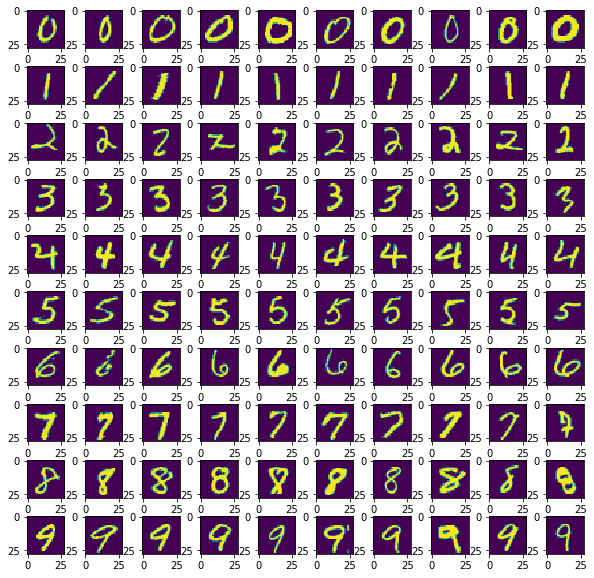

In [29]:
fig, axes = plt.subplots(10, 10,figsize=(10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(10):
    for j in range(10):
        indx = indexes[i][j]
        axes[i,j].imshow(test_samples[indx,:].reshape((28,28)))
        #plt.show()

In [38]:
hidden_out =np.argmax( hidden_5_output[:,np.random.randint(1024,size=10)] , axis= 1)
hidden_index = []
for i in range(10):
    hidden_index.append(np.ndarray.tolist((np.where(hidden_out == i)[0][:10])))
hidden_out.shape
hidden_index


[[5, 9, 21, 29, 31, 48, 53, 63, 66, 82],
 [0, 6, 45, 98, 99, 107, 120, 144, 170, 201],
 [],
 [50, 52, 77, 78, 83, 85, 87, 110, 114, 124],
 [8, 25, 33, 37, 38, 46, 73, 74, 76, 92],
 [7, 15, 16, 18, 19, 28, 49, 55, 60, 68],
 [1, 11, 12, 13, 17, 23, 24, 30, 34, 40],
 [36, 42, 117, 208, 244, 354, 466, 481, 504, 625],
 [2, 3, 4, 26, 27, 32, 39, 41, 51, 54],
 [10, 14, 20, 22, 35, 47, 59, 61, 62, 69]]

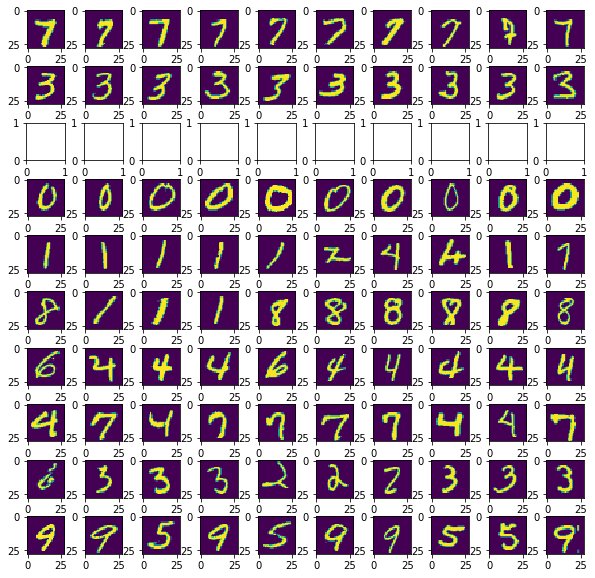

In [41]:
fig, axes = plt.subplots(10, 10,figsize=(10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(10):
    for j in range(10):
        if hidden_index[i]:
            indx = hidden_index[i][j]
            axes[i,j].imshow(test_samples[indx,:].reshape((28,28)))
            #plt.show()

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [43]:
test_samples = StandardScaler().fit_transform(test_samples)

In [44]:
pca = PCA(n_components= 2)

In [45]:
pcomp = pca.fit_transform(test_samples)

In [46]:
pcomp.shape
test_lb =[]
for i  in range(len(test_labels)):
    test_lb.append(np.argmax(test_labels[i]))
np.argmax(test_labels[0])

3

(1000,)


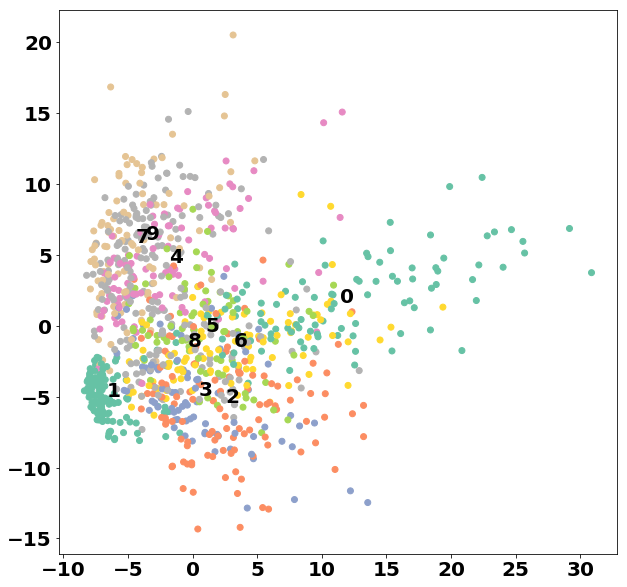

In [106]:
fig= plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 20
#plt.rcParams['font.weight'] = 'bold'
ax = fig.add_subplot(111)
ax.scatter(pcomp[:,0],pcomp[:,1], c =test_lb,cmap=plt.cm.get_cmap('Set2', 10) )

test_index = np.argmax(test_labels,axis=1)
print(test_index.shape)
mean = []
for i in range(10):
    indx = np.ndarray.tolist(np.where(test_index == i)[0])
    sub_samples = pcomp[indx]
   # print(sub_samples.shape)
    x,y = (np.mean(sub_samples, axis =0))
    ax.annotate(str(i), xy=(x,y))

In [77]:

#test_list    

(1000,)


In [94]:
import time

from sklearn.manifold import TSNE

In [95]:
test_samples_tsne = TSNE(n_components=2).fit_transform(test_samples)

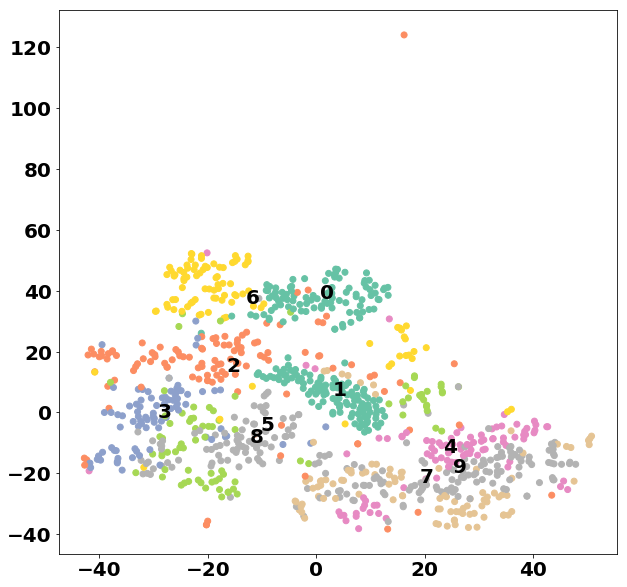

In [102]:
fig= plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 20
#plt.rcParams['font.weight'] = 'bold'
ax = fig.add_subplot(111)
ax.scatter(test_samples_tsne[:,0],test_samples_tsne[:,1], c =test_lb,cmap=plt.cm.get_cmap('Set2', 10) )

test_index = np.argmax(test_labels,axis=1)
#print(test_index.shape)
mean = []
for i in range(10):
    indx = np.ndarray.tolist(np.where(test_index == i)[0])
    sub_samples = test_samples_tsne[indx]
   # print(sub_samples.shape)
    x,y = (np.mean(sub_samples, axis =0))
    ax.annotate(str(i), xy=(x,y))